# Step 1 : Feature Matching

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import scipy.signal
import scipy.linalg
from scipy import ndimage
import math as m
from operator import itemgetter

270 480
270 480


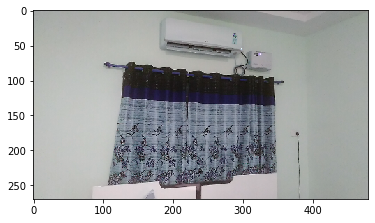

In [9]:
Imgs = []
for file in glob.glob('Data\FeatureMatching\Roo*.jpg'):
    img = cv2.imread(file)
    print(img.shape[0]//4, img.shape[1]//4)
    img =cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))
    plt.imshow(img)
    Imgs.append(img)

In [10]:
#lines which are commented in this class are only for reference & to be deleted afterwards

class FeatureMatching:
    
    def __init__(self, Imgs):
        self.Imgs = Imgs
        print(f'Number of images for feature matching : {len(self.Imgs)}')
    
    def GeneratePyramids(self, img_index, num_levels, subsample_factor, sigma_blur):
        self.pyramid_total_levels = num_levels
        self.pyramid_subsample_factor = subsample_factor
        self.pyramid_sigma_blur = sigma_blur
        
        img = self.Imgs[img_index]
        pyramids = [img]
        for i in range(1, self.pyramid_total_levels):
            pyramid = self.create_pyramid(pyramids[-1])
            pyramids.append(pyramid)
        return pyramids
    
    def create_pyramid(self, curr_level_img):
        plt.imshow(curr_level_img)
        img = cv2.GaussianBlur(curr_level_img, (5, 5), self.pyramid_sigma_blur)
        img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
        return img
    
    def boolean_R_at_all_levels(self, pyramids, sigma_gaussian, kernel_size, threshold, k):
        #img = self.Imgs[img_index]
        self.sigma_gaussian = sigma_gaussian
        self.k_size = kernel_size
        self.k = k
        self.thresh = threshold
        R_levels = []
        Orients = []
        descriptor_vector = []
        key_pts_at_all_scales = []
        curr_sigma = self.sigma_gaussian
        for i in range(self.pyramid_total_levels):
            pyramid = pyramids[i]
            kernel_list = self.kernel_gaussian_func(curr_sigma)
            curr_sigma = curr_sigma/self.k
            R_at_level = self.Compute_R_at_level(pyramid, kernel_list)
            R_image, list_of_i_points = self.Remove_nearest_neighbours(R_at_level)
            R_image, list_of_i_points = self.Thresholding(list_of_i_points, R_image, i)
            #print(list_of_i_points)
            R_image, list_of_i_points = self.AdaptiveNMS(list_of_i_points, R_image)
            R_image, list_of_i_points = self.Quadratic_Shifting(R_at_level, list_of_i_points)
            #print(len(list_of_i_points))
            
            if(len(list_of_i_points)!=0):
                arr_of_orients, list_of_orients = self.Orientation(pyramid, list_of_i_points)
                descript, kp = self.Descriptor(list_of_orients, pyramid)
                if(descript==None):
                    continue
                descriptor_vector.append(descript)
                key_pts_at_all_scales.append(kp)
                Orients.append(list_of_orients)#self.Orientation(pyramid, list_of_i_points))
            else:
                descriptor_vector.append([])
                key_pts_at_all_scales.append([])
                Orients.append(np.zeros((pyramid.shape[0],pyramid.shape[1],2)))
            R_levels.append(R_image)
        return R_levels, Orients, descriptor_vector, key_pts_at_all_scales
    
    def Descriptor(self, ls_of_orients, image):
        descriptor_vector = []
        key_pts = []
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("entered descriptor")
        
        ##now constructing a 3-cross-3 gaussian kernel to be used later
        size = 3
        gaussian = np.zeros((size,size))
        for i in range(size):
            y = i-size//2
            for j in range(size):
                x = j-size//2
                gaussian[i, j] = 1/(2*np.pi)*(np.exp((-1)*(x*x + y*y)*(1/2)))
        gaussian = gaussian/np.max(gaussian)
        ###construction of gaussian done
        
        for i in ls_of_orients:
            lstemp = []
            #print(i[3],i[2],(i[3]/i[2]))
            if(i[2]==0.0):
                if(i[3]>0):
                    angle = 1.57
                elif(i[3]<0):
                    angle = -1.57 
            else:
                angle = m.atan(i[3]/i[2])
            patch = self.patchmaker(image, 12, 12, i[0], i[1], angle)
            if(patch.shape[0]==1):
                continue
            j_grad = np.zeros((10, 10))
            i_grad = np.zeros((10, 10))
            for i1 in range(10):
                for j1 in range(1, 11):
                    j_grad[i1, j1-1] = patch[i1, j1+1]-patch[i1, j1-1]
            for j1 in range(10):
                for i1 in range(1, 11):
                    i_grad[i1-1, j1] = patch[i1+1, j1]-patch[i1-1, j1]
            j_grad = scipy.signal.convolve2d(j_grad, gaussian, mode='valid')
            i_grad = scipy.signal.convolve2d(i_grad, gaussian, mode='valid')
            #print(i_grad.shape)
            factor_dx = 0.0
            factor_dy = 0.0
            factor_absdx = 0.0
            factor_absdy = 0.0
            for i1 in range(0,4):
                for j1 in range(0,4):
                    dx = j_grad[2*i1,2*j1]+j_grad[2*i1+1,2*j1]+j_grad[2*i1,2*j1+1]+j_grad[2*i1+1,2*j1+1]
                    dy = i_grad[2*i1,2*j1]+i_grad[2*i1+1,2*j1]+i_grad[2*i1,2*j1+1]+i_grad[2*i1+1,2*j1+1]
                    abs_dx = abs(j_grad[2*i1,2*j1])+abs(j_grad[2*i1+1,2*j1])+abs(j_grad[2*i1,2*j1+1])+abs(j_grad[2*i1+1,2*j1+1])
                    abs_dy = abs(i_grad[2*i1,2*j1])+abs(i_grad[2*i1+1,2*j1])+abs(i_grad[2*i1,2*j1+1])+abs(i_grad[2*i1+1,2*j1+1])
                    factor_dx = factor_dx + dx*dx
                    factor_dy = factor_dy + dy*dy
                    factor_absdx = factor_absdx + abs_dx*abs_dx
                    factor_absdy = factor_absdy + abs_dy*abs_dy
                    lstemp.append(dx)
                    lstemp.append(dy)
                    lstemp.append(abs_dx)
                    lstemp.append(abs_dy)
            factor_dx = m.sqrt(factor_dx)
            factor_dy = m.sqrt(factor_dy)
            factor_absdx = m.sqrt(factor_absdx)
            factor_absdy = m.sqrt(factor_absdy)
            for q in range(0,16):
                lstemp[4*q] = lstemp[4*q]/factor_dx
                lstemp[4*q+1] = lstemp[4*q+1]/factor_dy
                lstemp[4*q+2] = lstemp[4*q+2]/factor_absdx
                lstemp[4*q+3] = lstemp[4*q+3]/factor_absdy
            key_pts.append([i[0], i[1]])
            descriptor_vector.append(lstemp)     #(x,y,descriptor) for each point
        print("leaving descriptor")
        return descriptor_vector, key_pts
                
    def patchmaker(self, img, height, width, center_y, center_x, theta):
        #print("making patch")
        #theta = angle/180*3.14
        img_shape = np.shape(img)
        if(img.shape[0]<height or img.shape[1]<width):
            print('found zero')
            return np.zeros((1,1))
        #print(img_shape)
        x = [[i for i in range(0,img_shape[1])] for y in range(img_shape[0])]
        y = [[j for i in range(img_shape[1])] for j in range(0,img_shape[0])]
        x = np.asarray(x)
        y = np.asarray(y)
        rotatex = x[center_y-m.floor(height/2):center_y+m.floor(height/2),center_x-m.floor(width/2):center_x+m.floor(width/2)]
        rotatey = y[center_y-m.floor(height/2):center_y+m.floor(height/2),center_x-m.floor(width/2):center_x+m.floor(width/2)]
        if(rotatex.shape[0]==0 or rotatex.shape[1]==0 or rotatey.shape[0]==0 or rotatey.shape[1]==0):
            print(rotatex.shape, rotatey.shape)
            return np.array([[1]])
        coords   = [rotatex.reshape((1,height*width))-center_x,rotatey.reshape((1,height*width))-center_y]
        coords = np.asarray(coords)
        coords = coords.reshape(2,height*width)
        roatemat = [[m.cos(theta),m.sin(theta)],[-m.sin(theta),m.cos(theta)]]
        rotatedcoords = np.matmul(roatemat,coords)
        patch = ndimage.map_coordinates(img,[rotatedcoords[1]+center_y,rotatedcoords[0]+center_x], order=1, mode='nearest').reshape(height,width)
        return patch
    
    def Quadratic_Shifting(self, R, list_of_i_points):
        print("entered quad shift")
        image = np.zeros(R.shape)
        ls = []
        for i in list_of_i_points:
            delRdeli = (R[(i[1]+1),i[2]]-R[(i[1]-1),i[2]])/2
            delRdelj = (R[i[1],(i[2]+1)]-R[i[1],(i[2]-1)])/2
            delR = np.array([[delRdeli], [delRdelj]])
            del2Rdeli2 = R[(i[1]+1),i[2]]-(2*R[i[1],i[2]])+R[(i[1]-1),i[2]]
            del2Rdelj2 = R[(i[1]),(i[2]+1)]-(2*R[i[1],i[2]])+R[(i[1]),(i[2]-1)]
            del2Rdelidelj = (R[(i[1]+1),(i[2]+1)] + R[(i[1]-1),(i[2]-1)] - R[(i[1]+1),(i[2]-1)] - R[(i[1]-1),(i[2]+1)])/4
            del2R = np.array([[del2Rdeli2, del2Rdelidelj],[del2Rdelidelj, del2Rdelj2]])
            x_matrix = np.array([[i[1]], [i[2]]]) - np.dot((np.linalg.inv(del2R)),delR)
            x_matrix = np.round(x_matrix)
            #print(int(x_matrix[0, 0]), int(x_matrix[1, 0]))
            if(int(x_matrix[0, 0])>=image.shape[0] or int(x_matrix[1, 0])>=image.shape[1]):
                image[i[1], i[2]]=R[i[1],i[2]]
                ls.append([R[i[1], i[2]], i[1], i[2]])
            else:
                image[int(x_matrix[0, 0]), int(x_matrix[1, 0])] = R[i[1], i[2]]
                ls.append([R[i[1], i[2]], int(x_matrix[0, 0]), int(x_matrix[1, 0])])
        print("leaving quad shift")
        return image, ls
    
    def Orientation(self, pyramid, lis):
        print("entered orient")
        pyramid = cv2.cvtColor(pyramid, cv2.COLOR_BGR2GRAY)
        #print(pyramid.shape)
        #print(len(lis[0]))
        ls = []
        x_kernel, y_kernel = self.kernel_gaussian_func(4.5)
        size = self.k_size
        oriented_array = np.zeros((pyramid.shape[0], pyramid.shape[1], 2))
        for i in lis:
            if(i[1]<5 or i[2]<5 or (i[1]>pyramid.shape[0]-7) or (i[2]>pyramid.shape[1]-7)):
                continue
            temp_x = 0.0
            temp_y = 0.0
            if((i[2]>pyramid.shape[1]-size//2-1) or (i[2]<size//2) or (i[1]>pyramid.shape[0]-size//2-1) or (i[1]<size//2)):
                temp_x = pyramid[i[1], (i[2]+1)] - pyramid[i[1], (i[2]-1)]
                temp_y = pyramid[(i[1]+1), i[2]] - pyramid[(i[1]-1), i[2]]
            else:
                for y in range((i[1]-size//2),(i[1]+1+size//2)):
                    for x in range((i[2]-size//2),(i[2]+1+size//2)):
                        temp_x = temp_x+(pyramid[y, x]*x_kernel[(y-i[1]+size//2), (x-i[2]+size//2)])
                        temp_y = temp_y+(pyramid[y, x]*y_kernel[(y-i[1]+size//2), (x-i[2]+size//2)])
                    #print(temp_x.shape, temp_y.shape)
                if(temp_y==0 and temp_x==0):
                    temp_x = pyramid[i[1], (i[2]+1)] - pyramid[i[1], (i[2]-1)]
                    temp_y = pyramid[(i[1]+1), i[2]] - pyramid[(i[1]-1), i[2]]
            factor = m.sqrt(temp_x*temp_x + temp_y*temp_y) 
            #print(temp_x.shape, temp_y.shape)
            if(temp_x==0 and temp_y==0):
                continue
            ls.append([i[1],i[2], temp_x/factor, temp_y/factor]) #i,j,costheta,sintheta 
            oriented_array[i[1], i[2], 0] = temp_x/factor
            oriented_array[i[1], i[2], 1] = temp_y/factor
            #print("reached end of orientation"
        print("leaving orient")
        return oriented_array, ls
    
    def Thresholding(self, list_of_i_points, R_image, curr_level):
        ls = []
        img = np.zeros(R_image.shape)
        for i in list_of_i_points:
            if((i[0]/((self.k*self.k)**curr_level))>self.thresh):
                ls.append(i)
                img[i[1], i[2]] = i[0]
        return img, ls
    
    def AdaptiveNMS(self, ls, R_image):
        print("entered NMS")
        list_of_points = []
        if(len(ls)<500):
            print("leaving NMS")
            return R_image,ls
        for point in ls:
            R, i, j = point
            if(i<5 or j<5 or (i>(R_image.shape[0]-7)) or (j>(R_image.shape[1]-7))):
                continue
            dist = 10000
            for other_point in ls:
                R_other, i_other, j_other = other_point
                if (i_other!=i or j_other!=j):
                    if(abs(i_other-i)>dist or abs(j_other-j)>dist or (R_other*0.9)<R ):
                        continue
                    else:
                        temp_dist = m.sqrt((i_other - i)**2 + (j_other - j)**2)
                        if(temp_dist<dist and (R_other*0.9)>R):
                            dist = temp_dist
                            temp_i = i
                            temp_j = j
                        else:
                            continue
                else:
                    continue
            list_of_points.append([dist, i, j])
        #print(len(list_of_points))
        lis = sorted(list_of_points, key=itemgetter(0), reverse=True)[:500]
        img = np.zeros(R_image.shape)
        for i in lis:
            img[i[1], i[2]] = R_image[i[1], i[2]]
        #print(len(lis))
        #print(img.shape)
        print("leaving NMS")
        return img, lis
    
    def Remove_nearest_neighbours(self, R_image):
        imag = np.zeros(R_image.shape)
        ls=[]
        for i in range(1, R_image.shape[0]-1):
            for j in range(1, R_image.shape[1]-1):
                flag = 0
                for y in range(i-1, i+2):
                    for x in range(j-1, j+2):
                        if(x!=j and y!=i):
                            if(R_image[i, j] <= R_image[y, x]):
                                flag=1
                                break
                    if(flag==1):
                        break
                if(flag==1):
                    imag[i, j] = 0
                else:
                    imag[i, j] = R_image[i, j]
                    ls.append([R_image[i, j], i, j])
        return imag, ls
    
    def kernel_gaussian_func(self, sigma, size=2):
        ls = []
        if(size==2):
            size = self.k_size
        x_gaussian = np.zeros((size,size))
        for i in range(size):
            y = i-size//2
            for j in range(size):
                x = j-size//2
                x_gaussian[i, j] = -1/(2*np.pi*sigma*sigma*sigma*sigma)*(x*np.exp((-1)*(x*x + y*y)*(1/(sigma*sigma*2))))
        #x_gaussian = x_gaussian/(x_gaussian[0,0])
        ls.append(x_gaussian)
        #ls.append(np.round(x_gaussian))
        y_gaussian = np.zeros((size,size))
        for i in range(size):
            y = i-size//2
            for j in range(size):
                x = j-size//2
                y_gaussian[i, j] = -1/(2*np.pi*sigma*sigma*sigma*sigma)*(y*np.exp((-1)*(x*x + y*y)*(1/(sigma*sigma*2))))
        #y_gaussian = y_gaussian/(y_gaussian[0,0])
        ls.append(y_gaussian)
        #ls.append(np.round(y_gaussian))
        return ls
            
    def Compute_R_at_level(self, pyramid, kernel_list):
        print("entered Compute_R_at_level")
        k_size = self.k_size
        x_kernel, y_kernel = kernel_list
        image = cv2.cvtColor(pyramid, cv2.COLOR_BGR2GRAY)
        R_image = np.zeros(image.shape)
        #sum_Ixx = np.zeros(image.shape)
        #sum_Iyy = np.zeros(image.shape)
        #sum_Ixy = np.zeros(image.shape)
        window = np.zeros((3,3))
        for i in range(3):
            y = i-1
            for j in range(3):
                x = j-1
                window[i, j] = 1/(2*np.pi)*(np.exp(-1*((x*x + y*y)/2)))  #sigma of gaussian window is assumed 1.0 here
        #window = np.round(window/(window[0,0]))
        Ix = scipy.signal.convolve2d(image, x_kernel, mode='same', boundary='wrap')
        Iy = scipy.signal.convolve2d(image, y_kernel, mode='same', boundary='wrap')
        
        for i in range(1, (Ix.shape[0]-1)):
            for j in range(1, (Ix.shape[1]-1)):
                Ixx=0.0
                Iyy=0.0
                Ixy=0.0
                for y in range(i-1, i+2):
                    for x in range(j-1, j+2):
                        Ixx = Ixx+(Ix[y, x]*Ix[y, x]*window[y-i+1, x-j+1])
                        Iyy = Iyy+(Iy[y, x]*Iy[y, x]*window[y-i+1, x-j+1])
                        Ixy = Ixy+(Ix[y, x]*Iy[y, x]*window[y-i+1, x-j+1])
                        #sum_Ixx[i, j] = sum_Ixx[i, j]+(Ix[y, x]*Ix[y, x]*window[y-i+1, x-j+1])
                        #sum_Iyy[i, j] = sum_Iyy[i, j]+(Iy[y, x]*Iy[y, x]*window[y-i+1, x-j+1])
                        #sum_Ixy[i, j] = sum_Ixy[i, j]+(Ix[y, x]*Iy[y, x]*window[y-i+1, x-j+1])
                #eigen_values = (scipy.linalg.eig([[sum_Ixx[i, j], sum_Ixy[i, j]],[sum_Ixy[i, j], sum_Iyy[i, j]]]))[0].real
                #R_image[i, j] = (sum_Ixx[i, j]*sum_Iyy[i, j] - sum_Ixy[i, j]*sum_Ixy[i, j])/(sum_Ixx[i, j]+sum_Iyy[i, j])
                R_image[i, j] = (Ixx*Iyy - Ixy*Ixy)/(Ixx+Iyy)
        print("leaving Compute_R_at_level")
        return (R_image)#>self.thresh)

In [11]:
temp = FeatureMatching(Imgs)
temp

Number of images for feature matching : 2


In [12]:
#Imgs[0].shape
tmp = temp.GeneratePyramids(0, 1, 2, 1.5)
tmp1 = temp.GeneratePyramids(1, 1, 2, 1.5)

#plt.imshow(tmp,cmap=plt.cm.gray)
#plt.imshow(tmp1)
#plt.show()
#cv2.imshow("tmp",tmp[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [13]:
result, orientation, descriptor_vector_all_scales, key_pts = temp.boolean_R_at_all_levels(tmp, 1.5, 7, 5.0, 1.5)
result1, orientation1, descriptor_vector_all_scales1, key_pts1 = temp.boolean_R_at_all_levels(tmp1, 1.5, 7, 5.0, 1.5)

entered Compute_R_at_level
leaving Compute_R_at_level
entered NMS
leaving NMS
entered quad shift
leaving quad shift
entered orient
leaving orient
entered descriptor


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: overflow encountered in ubyte_scalars


leaving descriptor
entered Compute_R_at_level
leaving Compute_R_at_level
entered NMS
leaving NMS
entered quad shift
leaving quad shift
entered orient
leaving orient
entered descriptor
leaving descriptor


In [18]:
len(descriptor_vector_all_scales[0][1])
#np.array(descriptor_vector_all_scales[0],dtype=np.float32)

500

In [15]:
len(orientation[0][0])

4

In [34]:
np.array(descriptor_vector_all_scales[0], dtype='float32')

array([[0.2855149 , 0.4014568 , 0.2855149 , ..., 0.34686232, 0.24810892,
        0.34686232],
       [0.16755866, 0.36449403, 0.16755866, ..., 0.18145981, 0.38067627,
        0.18145981],
       [0.11770703, 0.06145939, 0.11770703, ..., 0.20220247, 0.14695418,
        0.20220247],
       ...,
       [0.23383157, 0.23705654, 0.23383157, ..., 0.25889397, 0.17835356,
        0.25889397],
       [0.37489814, 0.28380966, 0.37489814, ..., 0.12951739, 0.13764055,
        0.12951739],
       [0.2747991 , 0.07467677, 0.2747991 , ..., 0.36548793, 0.33409455,
        0.36548793]], dtype=float32)

## My matcher 

In [44]:
pairs = []
for i in range(len(key_pts[0])):
    mini = 64.0
    mini2 = 64.0
    pt1_i, pt1_j = key_pts[0][i]
    for j in range(len(key_pts1[0])):
        if(abs((orientation[0][i][3]/orientation[0][i][2])-(orientation1[0][j][3]/orientation1[0][j][2]))>(3.14159/20)):
            continue
        a = np.array(descriptor_vector_all_scales[0][i], dtype = np.float32)
        b = np.array(descriptor_vector_all_scales1[0][j], dtype = np.float32)
        tem = m.sqrt(np.sum(abs(a-b)*abs(a-b)))
        if(tem<mini):
            mini2 = mini
            mini = tem
            pt2_i, pt2_j = key_pts1[0][j]
        elif(tem>mini and tem<mini2):
            mini2 = tem
    if(mini<0.9 and mini2!= 64.0):
        #print(mini)
        if((mini2*0.75)<mini):
            continue
        else:
            pairs.append((pt1_i, pt1_j, pt2_i, pt2_j,mini))

#### end of my matcher

## Now displaying matches

In [48]:
te = cv2.cvtColor(tmp[0], cv2.COLOR_BGR2GRAY)
te1 = cv2.cvtColor(tmp1[0], cv2.COLOR_BGR2GRAY)

In [23]:
from scipy import ndimage
import numpy as np
import math as m
import cv2   
def patchmaker(img,height,width,center_y,center_x,theta):
    #theta = angle/180*3.14
    img_shape = np.shape(img)
    print(img_shape)
    x = [[i for i in range(0,img_shape[1])] for y in range(img_shape[0])]
    y = [[j for i in range(img_shape[1])] for j in range(0,img_shape[0])]
    x = np.asarray(x)
    y = np.asarray(y)
    rotatex = x[center_y-m.floor(height/2):center_y+m.floor(height/2),center_x-m.floor(width/2):center_x+m.floor(width/2)]
    rotatey = y[center_y-m.floor(height/2):center_y+m.floor(height/2),center_x-m.floor(width/2):center_x+m.floor(width/2)]
    coords   = [rotatex.reshape((1,height*width))-center_x,rotatey.reshape((1,height*width))-center_y]
    coords = np.asarray(coords)
    coords = coords.reshape(2,height*width)
    roatemat = [[m.cos(theta),m.sin(theta)],[-m.sin(theta),m.cos(theta)]]
    rotatedcoords = np.matmul(roatemat,coords)
    patch = ndimage.map_coordinates(img,[rotatedcoords[1]+center_y,rotatedcoords[0]+center_x], order=1, mode='nearest').reshape(height,width)
    return patch

In [54]:
size=50
index=54
cv2.imshow("win", patchmaker(te,size,size,pairs[index][0],pairs[index][1],0))
cv2.imshow("win2", patchmaker(te1,size,size,pairs[index][2],pairs[index][3],0))
cv2.waitKey(0)
cv2.destroyAllWindows()

(1152, 864)
(1152, 864)


### End of displaying matches

In [16]:
abs((orientation[0][0][3]/orientation[0][0][2])-(orientation1[0][0][3]/orientation1[0][0][2]))

0.7097300313955164

In [45]:
pairs = sorted(pairs, key=itemgetter(4))
print(pairs[:20])

[(802, 94, 841, 98, 0.2624442733922588), (189, 608, 222, 592, 0.2657386873085661), (189, 608, 222, 592, 0.2657386873085661), (463, 756, 483, 745, 0.31948286870091164), (463, 756, 483, 745, 0.31948286870091164), (834, 615, 854, 622, 0.32070031763072354), (929, 372, 853, 425, 0.34780956488139464), (832, 45, 871, 147, 0.3507695474350519), (457, 844, 474, 831, 0.35208083195145773), (457, 844, 474, 831, 0.35208083195145773), (459, 687, 480, 678, 0.37315454976245815), (459, 687, 480, 678, 0.37315454976245815), (493, 687, 513, 680, 0.3756887151469708), (293, 791, 482, 754, 0.38371116876619477), (293, 791, 482, 754, 0.38371116876619477), (792, 65, 832, 68, 0.3860158022316744), (174, 384, 533, 92, 0.43032886149897204), (174, 384, 533, 92, 0.43032886149897204), (942, 700, 873, 180, 0.43923029018292725), (942, 700, 873, 180, 0.43923029018292725)]


In [46]:
pairs[0]

(802, 94, 841, 98, 0.2624442733922588)

In [47]:
len(pairs)

55

In [133]:
check = cv2.circle(te, (pairs[1][1], pairs[1][0]), radius=10, color=(0, 0, 255), thickness=-1)
check1 = cv2.circle(te1, (pairs[1][3], pairs[1][2]), radius=10, color=(0, 0, 255), thickness=-1)
cv2.imshow("win", check1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [59]:
cv2.imshow("win", result1[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [34]:
check = cv2.circle(tmp[0], (pairs[20][0], pairs[20][1]), radius=5, color=(0, 0, 255), thickness=-1)
check1 = cv2.circle(tmp1[0], (pairs[50][2], pairs[50][3]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.imshow("win", tmp[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
len(pairs), len(key_pts[0]), len(key_pts1[0])

(499, 499, 500)

In [6]:
from numpy import save

In [7]:
save('result.npy', result)
save('result1.npy', result1)
save('orientation.npy', orientation)
save('orientation1.npy', orientation1)
save('orientation.npy', orientation)
save('descriptor_vector_all_scales.npy', descriptor_vector_all_scales)
save('descriptor_vector_all_scales1.npy', descriptor_vector_all_scales1)
save('key_pts.npy', key_pts)
save('key_pts1.npy', key_pts1)

NameError: name 'result' is not defined

In [8]:
result = np.load('result.npy')
result1 = np.load('result1.npy') 
orientation = np.load('orientation.npy')
orientation1 = np.load('orientation1.npy')
descriptor_vector_all_scales = np.load('descriptor_vector_all_scales.npy')
descriptor_vector_all_scales1 = np.load('descriptor_vector_all_scales1.npy')
key_pts = np.load('key_pts.npy')
key_pts1 = np.load('key_pts1.npy')

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(np.array(descriptor_vector_all_scales[0],dtype=np.float32),np.array(descriptor_vector_all_scales1[0],dtype=np.float32),k=2)
# Apply ratio test
good = []
for me,n in matches:
    if me.distance < 0.8*n.distance:
        good.append([me])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(tmp[0],cv2.KeyPoint_convert(np.array(key_pts[0],dtype = np.int8)),tmp1[0],cv2.KeyPoint_convert(np.array(key_pts1[0], dtype = np.int8)),good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [152]:
cv2.KeyPoint_convert()

cv2.KeyPoint

In [239]:
#plt.imshow(result[0], cmap=plt.cm.gray)
print(result[0].shape, tmp[0].shape)
cv2.imshow("win", result[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

(682, 1024) (682, 1024, 3)


In [129]:
ls = [[1,2,3],[1,2,3]]
a = np.array(ls, dtype=np.int8)

numpy.ndarray

In [ ]:
def Wrapper(Imgs):
    temp = FeatureMatching(Imgs)
    obj = []
    for i in range(len(Imgs)):
        temp.GeneratePyramids
        obj.append(temp.)

In [48]:
for i in range(result[1].shape[0]):
    for j in range(result[1].shape[1]):
        if(result[1][i, j]!=0.0):
            tmp[1] = cv2.circle(tmp[1], (j, i), radius=2, color=(0, 0, 255), thickness=-1)
cv2.imshow("win", tmp[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [49]:
descriptor_vector_all_scales[1][0]

[322,
 264,
 [118.0,
  510.0,
  118.0,
  510.0,
  315.0,
  258.0,
  315.0,
  258.0,
  76.0,
  26.0,
  76.0,
  26.0,
  122.0,
  763.0,
  122.0,
  763.0,
  339.0,
  1003.0,
  339.0,
  1003.0,
  287.0,
  492.0,
  287.0,
  492.0,
  106.0,
  1016.0,
  106.0,
  1016.0,
  340.0,
  933.0,
  340.0,
  933.0,
  437.0,
  722.0,
  437.0,
  722.0]]

## Kachra

In [107]:
(h, w) = tmp[2].shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), -30, 1.0)
cos = np.abs(M[0, 0])
sin = np.abs(M[0, 1])
M

array([[  0.8660254 ,  -0.5       , 100.93851278],
       [  0.5       ,   0.8660254 , -88.70765814]])

(72, 108)


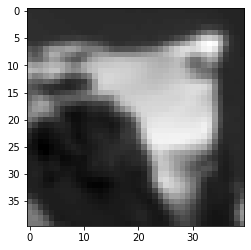

In [92]:
plt.imshow(patchmaker((cv2.cvtColor(tmp[4],cv2.COLOR_BGR2GRAY)),40,40,tmp[4].shape[0]//2,tmp[4].shape[1]//2,0.785),cmap=plt.cm.gray)

In [27]:
import math as m

(780, 1040, 3)
(780, 1040)


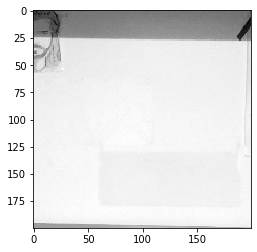

In [100]:
print(tmp[0].shape)
te = cv2.cvtColor(tmp[0], cv2.COLOR_BGR2GRAY)
plt.imshow(patchmaker(te, 200, 200, te.shape[0]//2, te.shape[1]//2, 0), cmap=plt.cm.gray)

In [53]:
from numpy import save

In [54]:
saver = result[1]>0.0
np.sum(saver)
save('layer1_interest_pts.npy',saver)

In [57]:
saver2 = tmp[1]
save('layer1_image.npy',saver2)

## Iske neeche bakwaas hai bas

In [18]:
cv2.imshow("win", result[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
res = np.zeros(result[2].shape)
count = 0
for i in range(result[2].shape[0]):
    for j in range(result[2].shape[1]):
        if((result[1][i, j])>10.0):
            res[i, j] = 255
            count = count+1
print(count)
cv2.imshow("win", res)
cv2.waitKey(0)
cv2.destroyAllWindows()

292


In [36]:
res = np.zeros(result[0].shape)
for i in range(result[0].shape[0]):
    for j in range(result[0].shape[1]):
        if(((result[0][i,j]))>10.0):
            res[i, j] = 1
        else:
            res[i, j] = 0
cv2.imshow("win", res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
imag = np.zeros(result[0].shape)
for i in range(1, result[0].shape[0]-1):
    for j in range(1, result[0].shape[1]-1):
        flag = 0
        for y in range(i-1, i+2):
            for x in range(j-1, j+2):
                if(x!=j and y!=i):
                    if(result[0][i, j] <= result[0][y, x]):
                        flag=1
                        break
            if(flag==1):
                break
        if(flag==1):
            imag[i, j] = 0
        else:
            imag[i, j] = result[0][i, j]
cv2.imshow("win", imag)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
cv2.imshow("win", res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
size=7
gaussian = np.zeros((size,size))
sigma=1.5
gaussian.shape

(7, 7)

In [27]:
x=2
y=1
np.exp((-1)*(x*x + y*y)*(1/(sigma*sigma*2)))

0.32919298780790557

In [28]:
np.exp()

ValueError: invalid number of arguments

In [29]:
for i in range(size):
    y = i-size//2
    for j in range(size):
        x = j-size//2
        gaussian[i,j]=-1*(x*np.exp((-1)*(x*x + y*y)*(1/(sigma*sigma*2))))
        
#gaussian = gaussian/(2*np.pi*sigma*sigma*sigma*sigma)
gaussian 

array([[ 0.05494692,  0.111276  ,  0.10836802, -0.        , -0.10836802,
        -0.111276  , -0.05494692],
       [ 0.16691399,  0.33802663,  0.32919299, -0.        , -0.32919299,
        -0.33802663, -0.16691399],
       [ 0.32510407,  0.65838598,  0.64118039, -0.        , -0.64118039,
        -0.65838598, -0.32510407],
       [ 0.40600585,  0.82222458,  0.8007374 , -0.        , -0.8007374 ,
        -0.82222458, -0.40600585],
       [ 0.32510407,  0.65838598,  0.64118039, -0.        , -0.64118039,
        -0.65838598, -0.32510407],
       [ 0.16691399,  0.33802663,  0.32919299, -0.        , -0.32919299,
        -0.33802663, -0.16691399],
       [ 0.05494692,  0.111276  ,  0.10836802, -0.        , -0.10836802,
        -0.111276  , -0.05494692]])

In [30]:
gaussian = gaussian/(gaussian[0,0])
#print(gaussian)
gaussian = np.round(gaussian)
print(gaussian)

[[  1.   2.   2.  -0.  -2.  -2.  -1.]
 [  3.   6.   6.  -0.  -6.  -6.  -3.]
 [  6.  12.  12.  -0. -12. -12.  -6.]
 [  7.  15.  15.  -0. -15. -15.  -7.]
 [  6.  12.  12.  -0. -12. -12.  -6.]
 [  3.   6.   6.  -0.  -6.  -6.  -3.]
 [  1.   2.   2.  -0.  -2.  -2.  -1.]]


In [15]:
image = cv2.cvtColor(tmp[0],cv2.COLOR_BGR2GRAY)
image.shape, gaussian.shape

((631, 977), (7, 7))

In [12]:
cv2.imshow("img", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
a = scipy.signal.convolve2d(image, gaussian, mode='same', boundary='wrap')
cv2.imshow("win",a)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
matr1 = np.array([[2,1],[1,2]])
matr2 = np.array([[1,2],[2,1]])
a = np.dstack([matr1,matr2])
a = a>1
a

array([[[ True, False],
        [False,  True]],

       [[False,  True],
        [ True, False]]])

In [25]:
(scipy.linalg.eig([[2, 1],[1, 2]]))[0].real

array([3., 1.])

In [17]:
window = np.zeros((3,3))
for i in range(3):
    y = i-1
    for j in range(3):
        x = j-1
        window[i,j] = np.exp(-1*((x*x + y*y)/2))
window = np.round(window/(window[0,0]))
window

array([[1., 2., 1.],
       [2., 3., 2.],
       [1., 2., 1.]])

In [165]:
ls = [1,2,3,4,5,2,1,3,4]
ls[2] = ls[2]/3
ls[2]

1.0

In [49]:
dic = {"a":1, "b":2, "1":3}


dict_keys

In [72]:
mat1 = np.array([[2,1],[1,2]])
mat2 = np.array([[2],[1]])
a = np.dot(mat1, mat2)

In [149]:
size = 3
x_gaussian = np.zeros((size,size))
for i in range(size):
    y = i-size//2
    for j in range(size):
        x = j-size//2
        x_gaussian[i, j] = 1/(2*np.pi)*(np.exp((-1)*(x*x + y*y)*(1/2)))
x_gaussian/np.max(x_gaussian)

array([[0.36787944, 0.60653066, 0.36787944],
       [0.60653066, 1.        , 0.60653066],
       [0.36787944, 0.60653066, 0.36787944]])